In [1]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

from funciones import plot_silhouette
from funciones import plot_silhouettes_and_sses
from funciones import get_silhouette_avg
from funciones import get_sse
from funciones import vanDongen
from funciones import hopkins

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE

from sklearn.cluster import AgglomerativeClustering

In [2]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

Se cargan los dataset

In [3]:
metadata = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis = pd.read_csv('../data/audio_analysis.csv', index_col='id')

audio_features = audio_features[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

# Para que las comparaciones sean del mismo largo,
# se remueve de audio_feature y metadata el track que no se encuentra en audio_analysis
merged = audio_features.merge(audio_analysis, how = 'left', on = 'id')
id_to_remove = merged[merged.timbre_mean_0.isnull()].index[0]

audio_features = audio_features.drop(id_to_remove, axis = 0)

audio_tracks = pd.merge(audio_features, audio_analysis, how = 'inner', on = 'id')
metadata = metadata.drop(id_to_remove, axis = 0)

# Se ordenan los datasets para que los tracks estén en el mismo orden
audio_features = audio_features.sort_index()
audio_analysis = audio_analysis.sort_index()
audio_tracks = audio_tracks.sort_index()
metadata = metadata.sort_index()

# Comentar si no se quiere estandarizar
audio_features_norm = scaler.fit_transform(audio_features)
audio_analysis_norm = scaler.fit_transform(audio_analysis)
audio_tracks_norm = scaler.fit_transform(audio_tracks)

In [4]:
features = pd.DataFrame(audio_features_norm)
analysis = pd.DataFrame(audio_analysis_norm)
tracks = pd.DataFrame(audio_tracks_norm)

features.to_csv('embedding_projector/audio_features.csv', index=False, sep='\t', header=False)
analysis.to_csv('embedding_projector/audio_analysis.csv', index=False, sep='\t', header=False)
tracks.to_csv('embedding_projector/audio_tracks.csv', index=False, sep='\t', header=False)

In [5]:
metadata.shape

(2205, 17)

In [6]:
audio_features.shape

(2205, 13)

In [7]:
audio_analysis.shape

(2205, 48)

In [8]:
audio_tracks.shape

(2205, 61)

# Tendencia al clustering (Hopkins)

In [27]:
hopkins(audio_features_norm)

Numero de puntos al azar por defecto


0.08059063830661234

In [28]:
hopkins(audio_analysis_norm)

Numero de puntos al azar por defecto


0.08442762169138371

In [29]:
hopkins(audio_tracks_norm)

Numero de puntos al azar por defecto


0.09781947338546644

# Cluster Jerárquico

0.7042391118575693

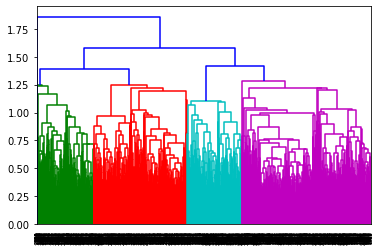

In [12]:
z = linkage(audio_features_norm, method = 'average', metric = 'euclidean')
plt.figure()
dn = dendrogram(z)
c, coph_dists = cophenet(z, pdist(audio_features_norm))
c

In [13]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
cluster.fit_predict(audio_features_norm)

tmp = pd.DataFrame({'Generos': metadata.genre, 'audio_features': cluster.labels_})
ct = pd.crosstab(tmp['Generos'], tmp['audio_features'])
ct

audio_features,0,1,2,3
Generos,,,,
ambient,208,65,187,0
classical,153,3,249,0
drum-and-bass,227,219,4,1
jazz,187,21,218,0
world-music,217,53,193,0


In [14]:
vanDongen(ct)

0.8781725888324873

In [15]:
adjusted_rand_score(metadata.genre, cluster.labels_)

0.06530326767596259

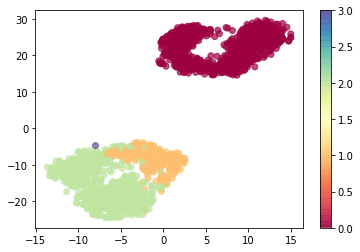

In [16]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_features_norm)
plt.scatter(Xred[:,0], Xred[:,1], c=cluster.labels_, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

In [17]:
'''
z = linkage(audio_analysis_norm, method = 'average', metric = 'euclidean')
plt.figure()
dn = dendrogram(z)
c, coph_dists = cophenet(z, pdist(audio_analysis_norm))
c
'''

"\nz = linkage(audio_analysis_norm, method = 'average', metric = 'euclidean')\nplt.figure()\ndn = dendrogram(z)\nc, coph_dists = cophenet(z, pdist(audio_analysis_norm))\nc\n"

In [18]:
'''
z = linkage(audio_tracks_norm, method = 'average', metric = 'euclidean')
plt.figure()
dn = dendrogram(z)
c, coph_dists = cophenet(z, pdist(audio_tracks_norm))
c
'''

"\nz = linkage(audio_tracks_norm, method = 'average', metric = 'euclidean')\nplt.figure()\ndn = dendrogram(z)\nc, coph_dists = cophenet(z, pdist(audio_tracks_norm))\nc\n"

In [19]:
'''
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')
cluster.fit_predict(audio_features_norm)

tmp = pd.DataFrame({'Generos': metadata.genre, 'audio_features': cluster.labels_})
ct = pd.crosstab(tmp['Generos'], tmp['audio_features'])
ct
'''

"\ncluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')\ncluster.fit_predict(audio_features_norm)\n\ntmp = pd.DataFrame({'Generos': metadata.genre, 'audio_features': cluster.labels_})\nct = pd.crosstab(tmp['Generos'], tmp['audio_features'])\nct\n"

In [20]:
# vanDongen(ct)

In [21]:
# adjusted_rand_score(metadata.genre, cluster.labels_)

# Hiperparametrización

In [22]:
'''
columns = ['Dataset', 'Method', 'Metric', 'Scaler', 'Cophenet', 'vanDongen', 'adjRand']
results = []

euclidean_methods = ['single', 'complete', 'average', 'ward']
methods = ['single', 'complete', 'average']

datasets = {
    "audio_features": audio_features,
    "audio_analysis": audio_analysis,
    "audio_tracks": audio_tracks
}

scalers = {
    "minMax": MinMaxScaler(feature_range=(0,1)),
    "standard": StandardScaler()
}

metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
           'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
           'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski',
           'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener',
           'sokalsneath', 'sqeuclidean']

for dataset in datasets.keys():
    for metric in metrics:
        possible_methods = euclidean_methods if metric == 'euclidean' else methods
        for method in possible_methods:
            for scaler in scalers.keys():
                print(dataset + ', ' + metric + ', ' + method + ', ' + scaler)
                df = scalers[scaler].fit_transform(datasets[dataset])
                z = linkage(df, method = method, metric = metric)
                c, coph_dists = cophenet(z, pdist(df))                    
                cluster = AgglomerativeClustering(n_clusters = 5, affinity = metric, linkage = method)
                cluster.fit_predict(datasets[dataset])
                tmp = pd.DataFrame({'Generos': metadata.genre, 'clusters': cluster.labels_})
                ct = pd.crosstab(tmp['Generos'], tmp['clusters'])
                vd = vanDongen(ct)
                rand = adjusted_rand_score(metadata.genre, cluster.labels_)                    
                results.append([dataset, method, metric, scaler, c, vd, rand])
                    
df_results = pd.DataFrame(results, columns = columns)
df_results
'''

'\ncolumns = [\'Dataset\', \'Method\', \'Metric\', \'Scaler\', \'Cophenet\', \'vanDongen\', \'adjRand\']\nresults = []\n\neuclidean_methods = [\'single\', \'complete\', \'average\', \'ward\']\nmethods = [\'single\', \'complete\', \'average\']\n\ndatasets = {\n    "audio_features": audio_features,\n    "audio_analysis": audio_analysis,\n    "audio_tracks": audio_tracks\n}\n\nscalers = {\n    "minMax": MinMaxScaler(feature_range=(0,1)),\n    "standard": StandardScaler()\n}\n\nmetrics = [\'braycurtis\', \'canberra\', \'chebyshev\', \'cityblock\',\n           \'correlation\', \'cosine\', \'dice\', \'euclidean\', \'hamming\',\n           \'jaccard\', \'kulsinski\', \'mahalanobis\', \'matching\', \'minkowski\',\n           \'rogerstanimoto\', \'russellrao\', \'seuclidean\', \'sokalmichener\',\n           \'sokalsneath\', \'sqeuclidean\']\n\nfor dataset in datasets.keys():\n    for metric in metrics:\n        possible_methods = euclidean_methods if metric == \'euclidean\' else methods\n      

In [23]:
# df_results.to_csv('hierarchical.csv', index = False)